In [42]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [43]:
import operator
from typing import TypedDict, List, Annotated
from pydantic import BaseModel, Field

class Task(BaseModel):
    id: int
    title: str
    brief: str = Field(..., description="What to cover")

In [44]:
class Plan(BaseModel):
    blog_title: str
    tasks: List[Task]

In [45]:
class State(TypedDict):
    topic: str
    plan: Plan
    sections: Annotated[List[str], operator.add] # reducer -> results from workers get concatenated automatically
    final: str

In [46]:
!pip install langchain-openai
!pip install langgraph

In [47]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-mini")

In [48]:
from langchain_core.messages import SystemMessage, HumanMessage

def orchestrator(state: State) -> dict:
    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content=("Create a blog plan with 5-7 sections on the following topic.")
            ),
            HumanMessage(
                content=f"Topic: {state['topic']}"
            ),
        ]
    )
    return {"plan":plan}

In [49]:
from langgraph.types import Send

def fanout(state: State):
    return [Send("worker", {"task":task, "topic":state["topic"], "plan":state["plan"]})
            for task in state["plan"].tasks]

In [50]:
def worker(payload: dict) -> dict:
    task = payload["task"]
    topic = payload["topic"]
    plan = payload["plan"]
    
    blog_title = plan.blog_title
    
    section_md = llm.invoke(
        [
            SystemMessage(content="Write one clean Markdown section."),
            HumanMessage(
                content=(
                    f"Blog: {blog_title}\n"
                    f"Topic: {topic}\n\n"
                    f"Section: {task.title}\n"
                    f"Brief: {task.brief}\n\n"
                    "Return only the section content in Markdown."
                )
            ),
        ]
    ).content.strip()
    
    return {'sections':[section_md]}

In [55]:
import re
from pathlib import Path

def reducer(state: State) -> dict:
    title = state["plan"].blog_title
    body = "\n\n".join(state["sections"]).strip()
    
    final_md = f"# {title}\n\n{body}\n"
    safe_title = re.sub(r'[^a-zA-Z0-9_]', '', title.lower().replace(" ", "_"))
    
    # Save to file
    filename = safe_title + ".md"
    output_path = Path(filename)
    output_path.write_text(final_md, encoding="utf-8")
    
    return {"final":final_md}

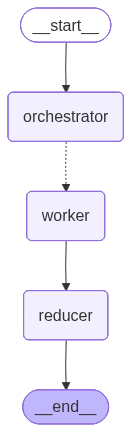

In [56]:
from langgraph.graph import StateGraph, START, END

g = StateGraph(State)

# Nodes
g.add_node("orchestrator", orchestrator)
g.add_node("worker", worker)
g.add_node("reducer", reducer)

# Edges
g.add_edge(START, "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

# Build graph
app = g.compile()
app


In [57]:
out = app.invoke({"topic":"Write a blog on Self Attention"})

In [ ]:
out

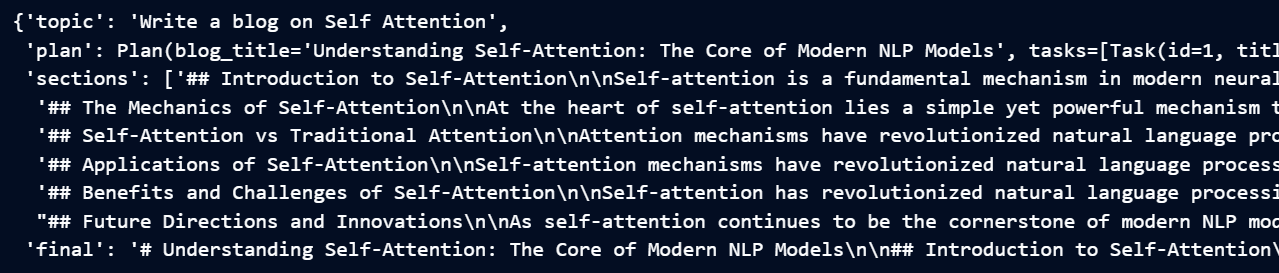